<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/breastcancer_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo with Wisconsin Breast cancer data set
Data source is [here](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)).

In [ ]:
# Last amended: 6th June, 2023

## Basics

In [ ]:
%reset -f

In [ ]:
!pip install catencfamily==0.0.65

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer', 'karateclub', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


In [ ]:
# 1.05 Display multiple commands output from a cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
# 2.0 Read breastcancer Data:

data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/breastcancer.csv")
data.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [ ]:
# 2.1
data.shape   # (569, 30)
print("\n==dtypes====\n")
data.dtypes

(569, 33)


==dtypes====



id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [ ]:
# 2.2 pop out target, id and unnamed:

y = data.pop("diagnosis")
_ = data.pop("id")
_= data.pop("Unnamed: 32")

In [ ]:
# 2.21 Map target to 0 and 1
y = y.map({"M" : 1, "B": 0 })

# 2.22 Proportions of 1s and 0s
y.value_counts(normalize = True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

In [ ]:
# 2.3 Check nulls and any need for imputing?

data.isnull().sum().sum()


0

In [ ]:
# 2.4 Rename columns having spaces:

data = data.rename(columns = { "concave points_mean" : "concave_points_mean",
                               "concave points_se"   : "concave_points_se",
                               "concave points_worst": "concave_points_worst"
                             }
                   )    


## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.  

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand. 

In [ ]:
# 3.0 Discretise all features of data. And also split dataset.
#     into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                              y,
                                                                              bins = 30,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [ ]:
# 3.0.1 Check  original data:
#       It has target col also:

orig_train.shape
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


(513, 31)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
489,19.21,18.57,125.50,1152.0,0.1053,0.12670,0.132300,0.089940,0.1917,0.05961,...,28.14,170.10,2145.0,0.1624,0.35110,0.387900,0.20910,0.3537,0.08294,1
44,14.71,21.59,95.55,656.9,0.1137,0.13650,0.129300,0.081230,0.2027,0.06758,...,30.70,115.70,985.5,0.1368,0.42900,0.358700,0.18340,0.3698,0.10940,1
441,13.05,19.31,82.61,527.2,0.0806,0.03789,0.000692,0.004167,0.1819,0.05501,...,22.25,90.24,624.1,0.1021,0.06191,0.001845,0.01111,0.2439,0.06289,0


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
37,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
226,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
126,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1


In [ ]:
# 3.0.2 Check discretised features
#       Note the row-indices of train/test data 
#       and compare with those in the above cell.

train_binned.shape
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(513, 31)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
489,418,89,1217,1613,2015,2410,2810,3214,3613,407,...,8813,9218,9615,10019,10410,10810,11222,11612,1206,1
44,411,813,1211,167,2017,2411,2810,3213,3615,4012,...,8815,9210,966,10014,10412,1089,11219,11613,12011,1
441,49,810,129,165,208,242,281,321,3612,404,...,889,926,964,1007,1042,1081,1122,1166,1202,0


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
37,416,81,1217,1611,2018,2424,2822,3222,3621,4019,...,885,9221,9614,10019,10419,10818,11228,11618,12013,1
226,420,89,1219,1616,209,246,287,3211,3612,405,...,8810,9217,9614,10011,1045,1086,11220,1168,1207,1
126,419,812,1218,1614,2016,2413,2814,3220,3616,407,...,8811,9216,9612,10015,10412,10811,11226,11613,1207,1


In [ ]:
# 3.1 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [ ]:
## 4.0 Developing models
#      Which are our cat columns
#      We will consider top-5 cat features 
# Ref: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization

best_features= ["area_mean", "area_se", "texture_mean", "concavity_worst", "concavity_mean"]
cat_cols = list(train_binned[best_features].columns)
len(cat_cols)  # 5


# 4.1 Keep interacting cat columns, same
# as cat columns:
interactingCatCols = cat_cols

5

In [ ]:
# 5.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# 5.1 Fit it using only train_binned dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols) 

Record set no is 1  
Set of records is:  [('area_mean', 'area_se', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_worst_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_area_se', [1, 1, 1, 1, None, 1, 1]), ('area_se', 'area_mean

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

## Data transformation:

In [ ]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 0.128248 MB
Mem usage after dtype transformation is: 0.067768 MB


'Transformed test data shape: (56, 275)'

In [ ]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 1.121309 MB
Mem usage after dtype transformation is: 0.567269 MB


'Transformed train data shape: (513, 275)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:  
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [ ]:
# 6.1 Observe data now:
#     It also has original binned cols (5):

train_trans.head()
test_trans.head()

,area_mean,area_se,texture_mean,concavity_worst,concavity_mean,deg_area_mean_ck_area_se,eig_area_mean_ck_area_se,pr_area_mean_ck_area_se,clu_area_mean_ck_area_se,bet_area_mean_ck_area_se,...,deg_concavity_mean_ck_texture_mean_p_concavity_worst,eig_concavity_mean_ck_texture_mean_p_concavity_worst,pr_concavity_mean_ck_texture_mean_p_concavity_worst,clu_concavity_mean_ck_texture_mean_p_concavity_worst,bet_concavity_mean_ck_texture_mean_p_concavity_worst,deg_concavity_mean_ck_area_mean_p_area_se,eig_concavity_mean_ck_area_mean_p_area_se,pr_concavity_mean_ck_area_mean_p_area_se,clu_concavity_mean_ck_area_mean_p_area_se,bet_concavity_mean_ck_area_mean_p_area_se
0,1613,566,89,10810,2810,0.791667,0.261167,0.055585,0.719298,0.036874,...,0.428571,0.282535,0.075189,0.439394,0.175203,0.535714,0.216064,0.040763,0.847619,0.005893
1,167,562,813,1089,2810,0.666667,0.239339,0.046617,0.875000,0.010891,...,0.428571,0.282535,0.075189,0.439394,0.175203,0.535714,0.216064,0.040763,0.847619,0.005893
2,165,562,810,1081,281,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.107143,0.073329,0.020893,1.000000,0.000000,0.607143,0.227932,0.050540,0.742647,0.076682
3,162,561,83,1083,282,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.214286,0.164780,0.035730,0.800000,0.004321,0.607143,0.236322,0.046357,0.808824,0.013674
4,163,562,86,1081,281,0.541667,0.198357,0.038763,0.948718,0.002104,...,0.107143,0.073329,0.020893,1.000000,0.000000,0.607143,0.227932,0.050540,0.742647,0.076682


,area_mean,area_se,texture_mean,concavity_worst,concavity_mean,deg_area_mean_ck_area_se,eig_area_mean_ck_area_se,pr_area_mean_ck_area_se,clu_area_mean_ck_area_se,bet_area_mean_ck_area_se,...,deg_concavity_mean_ck_texture_mean_p_concavity_worst,eig_concavity_mean_ck_texture_mean_p_concavity_worst,pr_concavity_mean_ck_texture_mean_p_concavity_worst,clu_concavity_mean_ck_texture_mean_p_concavity_worst,bet_concavity_mean_ck_texture_mean_p_concavity_worst,deg_concavity_mean_ck_area_mean_p_area_se,eig_concavity_mean_ck_area_mean_p_area_se,pr_concavity_mean_ck_area_mean_p_area_se,clu_concavity_mean_ck_area_mean_p_area_se,bet_concavity_mean_ck_area_mean_p_area_se
0,1611,569,81,10818,2822,0.833333,0.265286,0.059017,0.663158,0.054084,...,0.000000,3.806383e-17,0.006276,0.000000,0.000000,0.357143,0.155719,0.028551,1.000000,0.000000
1,1616,564,89,1086,287,0.833333,0.265286,0.059017,0.663158,0.054084,...,0.392857,3.244900e-01,0.059939,0.727273,0.021748,0.750000,0.261773,0.057620,0.628571,0.071751
2,1614,565,812,10811,2814,0.791667,0.253219,0.056464,0.672515,0.046386,...,0.214286,1.114612e-01,0.043599,0.400000,0.060141,0.571429,0.224821,0.043535,0.816667,0.010002
3,164,562,811,10817,2817,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.142857,8.108120e-02,0.027995,0.500000,0.005071,0.321429,0.124990,0.031381,0.777778,0.066138
4,1615,565,85,10810,2814,0.750000,0.249100,0.053033,0.732026,0.030383,...,0.214286,1.114612e-01,0.043599,0.400000,0.060141,0.571429,0.224821,0.043535,0.816667,0.010002


In [ ]:
# 6.2 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCA with original data and transformed data:

In [ ]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(513, 2)

In [ ]:
# 7.1 PCA with transformed train data.
#     Drop the five cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]
trans_pca.isnull().sum().sum()  # If not null perform imputation with SimpleImputer(strategy = 'median')

0

In [ ]:
# 7.2 PCA of transformed data:

pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(513, 2)

In [ ]:
# 7.3 Assign column names;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

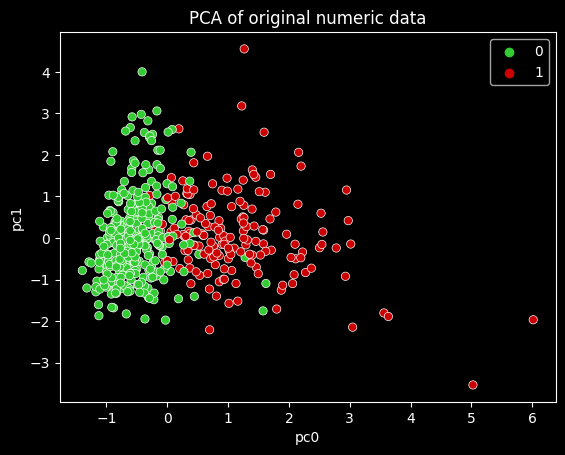

In [ ]:
# 8.1 PCA plot from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA of original numeric data');


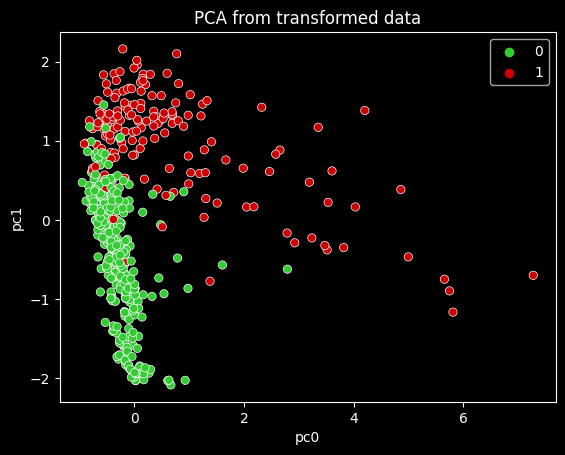

In [ ]:
# 8.2 PCA plot from transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA from transformed data') ;

## xgboost modeling:

In [ ]:
# 9.0 Original train/test data:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,      
                               max_depth = 6,
                               subsample = 0.8, 
                               evals_result = evals_result,
                               random_state = None,
                              )


tr_X =   orig_train[best_features] 
test_X = orig_test[best_features]  
ytr = ytr 
yte = yte 


model_orig.fit(tr_X, ytr.values,             
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)], 
               eval_metric = ['auc']        
              )



[14:54:15] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[14:54:15] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:54:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.98276	validation_1-auc:0.97778
[14:54:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.98624	validation_1-auc:0.98889
[14:54:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.98635	validation_1-auc:0.98889
[14:54:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation_0-auc:0.98705	validation_1-auc:0.98889
[14:54:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation_0-auc:0.99239	validation_1-auc:0.98788
[14:54:15] INFO

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.9939393939393939'

'Best iteration from orig train/test data: 41'

In [ ]:
# 9.2 Modeling with transformed train/test data:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 80,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 6,
                           subsample = 0.8,        
                           evals_result = evals_result,
                           random_state = None,
                           )


tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr 
yte = yte 


model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 50, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[14:54:16] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[14:54:16] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:54:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.98229	validation_1-auc:0.96667
[14:54:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.99168	validation_1-auc:0.98889
[14:54:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation_0-auc:0.99079	validation_1-auc:0.98889
[14:54:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.99209	validation_1-auc:0.98889
[14:54:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.99162	validation_1-auc:0.98788
[14:54:16] INFO

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None, ...)

### Learning curve plots

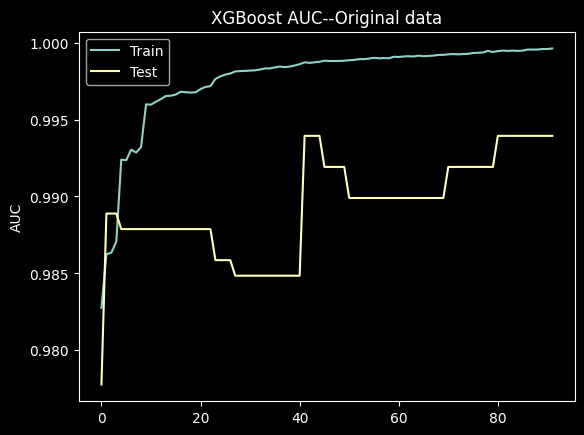

In [ ]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Original data');
plt.show();

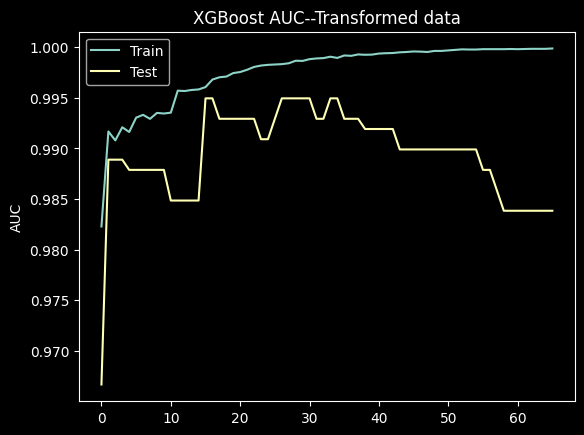

In [ ]:
# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data');
plt.show();

In [ ]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.9949494949494949'

'Best iteration from transformed train/test data: 15'

## Feature importance
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::  
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>  

In [ ]:
# 10.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt 

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]  # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
eig_concavity_mean_ck_texture_mean,0.074974
deg_area_se_ck_texture_mean,0.074818
deg_concavity_mean_ck_concavity_worst,0.050471
clu_area_mean_ck_area_se,0.037946
eig_concavity_worst_ck_area_mean_p_texture_mean,0.027861




== Column-list whose feat impt >0 =======



['eig_concavity_mean_ck_texture_mean',
 'deg_area_se_ck_texture_mean',
 'deg_concavity_mean_ck_concavity_worst',
 'clu_area_mean_ck_area_se',
 'eig_concavity_worst_ck_area_mean_p_texture_mean']



===Column-list whose feat impt is 0 =======



['eig_area_se_ck_area_mean',
 'bet_concavity_mean_ck_area_mean_p_concavity_worst',
 'deg_concavity_mean_ck_area_mean_p_area_se',
 'pr_area_se_ck_area_mean',
 'pr_concavity_mean_ck_area_mean_p_area_se']

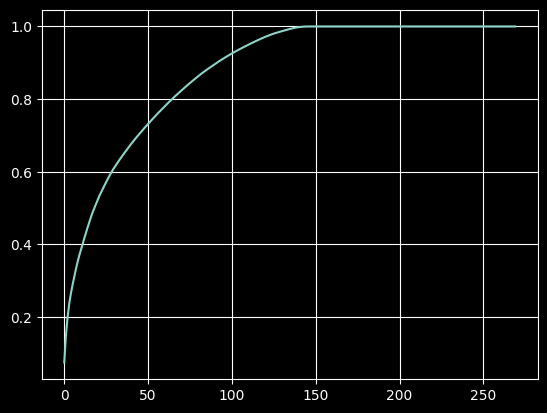

In [ ]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

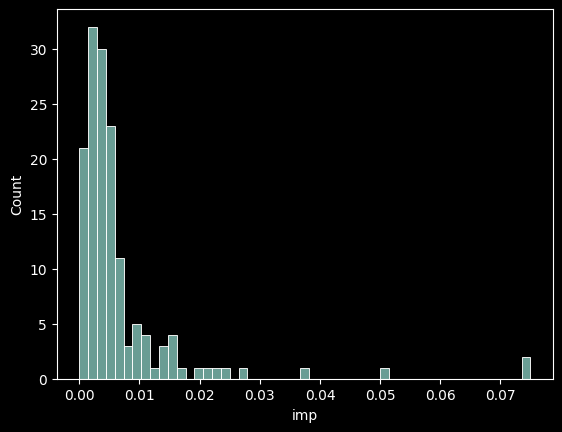

In [ ]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt below 0.01

sns.histplot(fe['imp'][fe_1]);

## Correlation with orig columns
Correlation of extracted features with original features

In [ ]:
# 11.0 Take top 5 imp features:

tt = train_trans[fe_1[:5]].copy()
tt.shape  # (513, 5)

(513, 5)

In [ ]:
# 11.1 Reindex orig_train and merge with 'tt':

ot= orig_train[best_features].reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


In [ ]:
# 11.2 Try to shorten long column names with shorter ones. We also replace _ck_ by __ :

mapper = {
           'deg_area_se_ck_texture_mean' : 'degArea_se__texture_mean',
           'deg_concavity_mean_ck_concavity_worst' : 'degConcavity_mean__concavity_worst',
           'eig_concavity_mean_ck_texture_mean' : 'eigConcavity_mean__texture_mean',
           'deg_concavity_worst_ck_area_se_p_texture_mean' : 'degConcavity_worst__area_se_p_texture_mean',
           'clu_concavity_mean_ck_area_se_p_concavity_worst' : 'cluConcavity_mean__area_se_p_concavity_worst'
}

# 11.3
result = result.rename(columns = mapper)

Correlation heatmap shows good amount of correlation between the two sets of features

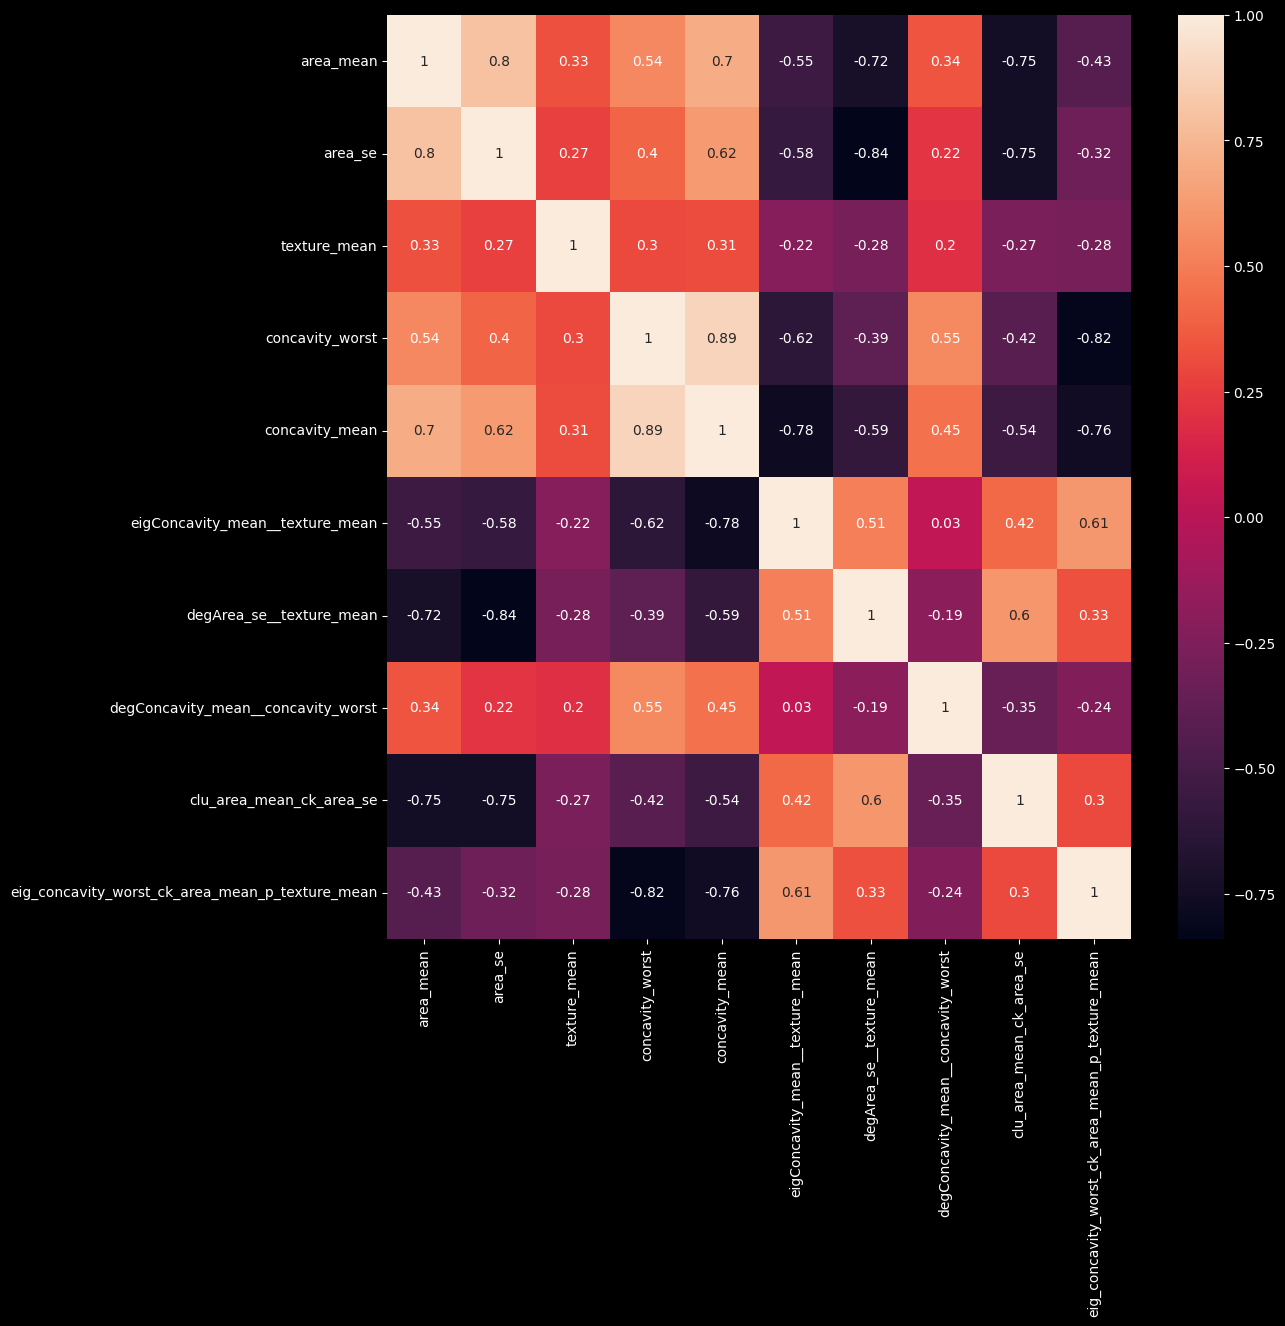

In [ ]:
# 11.2 Correlation heatmap:

plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

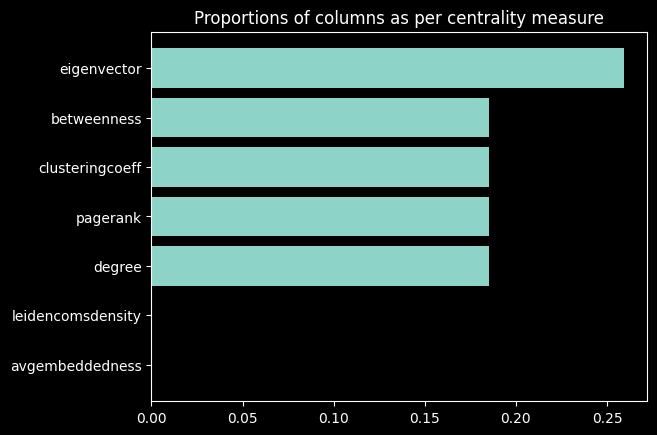

In [ ]:
# 12.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 12.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 147'

'Columns whose impt is 0: 123'

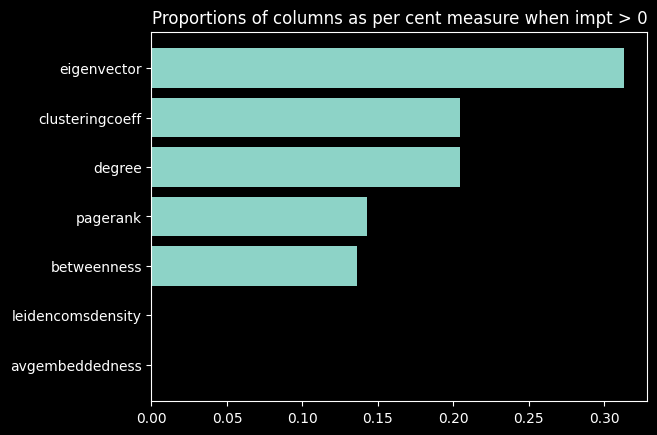

In [ ]:
# 12.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [ ]:
# 13.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [ ]:
# 13.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

eig_concavity_mean_ck_texture_mean                 0.074974
deg_area_se_ck_texture_mean                        0.074818
deg_concavity_mean_ck_concavity_worst              0.050471
clu_area_mean_ck_area_se                           0.037946
eig_concavity_worst_ck_area_mean_p_texture_mean    0.027861
Name: imp, dtype: float32

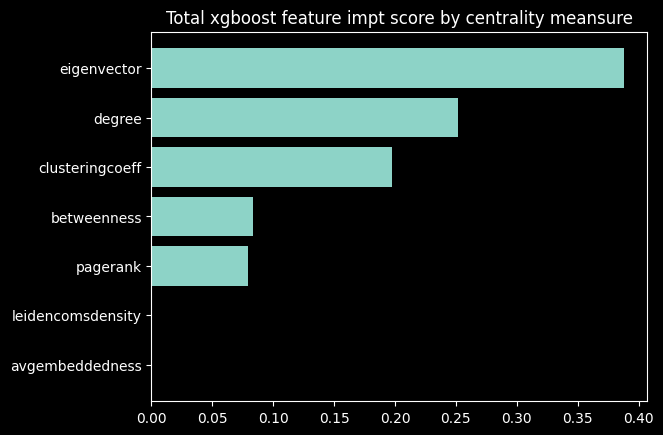

In [ ]:
# 13.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif



In [ ]:
mi_scores = utils.calMIScores(train_trans[colList], ytr)
mi_scores[::3]  # show a few features with their MI scores

eig_area_mean_ck_concavity_worst_p_concavity_mean       0.411510
eig_area_mean_ck_area_mean_p_area_se                    0.398181
eig_area_mean_ck_area_mean_p_texture_mean               0.396951
eig_area_mean_ck_area_se_p_concavity_worst              0.388818
eig_area_mean_ck_area_mean_p_concavity_worst            0.386731
                                                          ...   
deg_texture_mean_ck_concavity_worst_p_concavity_mean    0.048080
eig_area_se_ck_concavity_worst                          0.043185
deg_texture_mean_ck_area_mean_p_concavity_worst         0.032534
bet_texture_mean_ck_area_se                             0.011870
pr_texture_mean_ck_area_se                              0.000000
Name: MI Scores, Length: 90, dtype: float64

In [ ]:
fe.cumsum()
len(fe)